In [3]:
import re
import time
import datetime
from crawling import *

In [4]:
def geturl(parsed_html):
    result = []
    elements = parsed_html.select("tbody > tr > td:nth-child(1) > a:nth-child(1)")
    for element in elements:
        result.append("https://namu.wiki" + element.attrs.get("href"))
    return result

def gettime(parsed_html):
    alltimes = parsed_html.select("tr time")
    lasttime = datetime.datetime(*map(int, re.split("[-: ]+", alltimes[0].text)))
    firsttime = datetime.datetime(*map(int, re.split("[-: ]+", alltimes[-1].text)))
    return (lasttime - firsttime).seconds//2

In [62]:
page_urls = {}
origin_url = r"https://namu.wiki/RecentChanges"
# get urls until input limit
url_limit = int(input())
while True:
    namu_recent = html_parser(origin_url, 5)
    if namu_recent is not None:
        # get url
        for url in geturl(namu_recent):
            page_urls[url] = page_urls.get(url, 0) + 1
        print("url number:", len(page_urls))
        if len(page_urls) > url_limit:
            break
        # get time dif
        timedif = gettime(namu_recent)
        print(f"waiting time: {timedif}s")
        time.sleep(timedif)

url number: 86


In [63]:
cnt = 0
titles, categories, paragraphs = [],[],[]
for target_url in page_urls:
    if cnt >= 10:
        break
    cnt += 1
    namu_keyword = html_parser(target_url)
    if namu_keyword is not None:
        article = namu_keyword.select_one("article")
        title = get_text(article.select_one("h1"))
        raw_categories = list(article.select_one("h2").next_siblings)[-1].select("li")
        category = "&".join(get_text(raw_categories))
        # remove unnecessary info
        for i in article.select("table"):         
            i.clear()
        # get paragraph data
        if article.select_one(".wiki-heading-content") is None:
            raw_paragraphs = article.select(".wiki-paragraph")
        else:
            raw_paragraphs = article.select(".wiki-heading-content>.wiki-paragraph")
        paragraph = "&".join(get_text(raw_paragraphs))
        titles.append(title)
        categories.append(category)
        paragraphs.append(paragraph)

In [64]:
import pandas
df = pandas.DataFrame(data={"title":titles, "category":categories, "paragraph":paragraphs})
df

,title,category,paragraph
0,유희왕 마스터 듀얼,유희왕 마스터 듀얼,"2022년 1월 19일에 코나미에서 제작, 출시한 유희왕 오피셜 카드게임 기반의 유..."
1,무까끼하이,랩&한국 힙합 노래&2011년 노래&한국대중음악상 수상,2011년 MC메타와 DJ 렉스 (DJ WRECKX)가 함께한 프로젝트 힙합 듀오인...
2,서울특별시 시내버스/2004년 개편 전 목록/50번대,서울특별시의 시내버스,1970년 4월 1일 개편으로 정릉부터 시계 방향으로 돌아가는 방식으로 1번부터 1...
3,에이지 오브 엠파이어 3,에이지 오브 엠파이어 3,이 트레일러가 공개될 당시 AOE 팬들에게는 말그대로 혁명적인 반응을 불러일으켰다....
4,엘 루비오,Grand Theft Auto Online/등장인물,&&GTA 온라인: 카요 페리코 습격의 등장인물이자 카요 페리코 습격의 메인 빌런이...
5,레오나르두 나시멘투 로페스 지수자,"1997년 출생&소로카바 출신 인물&브라질의 축구선수&공격수&이투아누 FC/은퇴, ...","브라질의 축구선수다. 현재 산둥 타이산에서 뛰고 있다.&레드불 브라질[2], SC ..."
6,피카츄(Pokémon UNITE),Pokémon UNITE&피카츄,포켓몬 유나이트에 등장하는 포켓몬스터의 캐릭터 피카츄에 관해 서술하는 문서&스타팅 ...
7,마방 기사 가이아,유희왕/OCG/전사족,&룰상 암흑 기사 가이아 카드로도 취급되는 효과 외 텍스트를 가진 몬스터.①의 효과...
8,MC메타,한국의 남성 래퍼&힙합 래퍼&1971년 출생&1997년 데뷔&서구(대구) 출신 인물...,"MC메타는 대한민국의 힙합 MC이자, 가리온의 멤버로, 한국 언더그라운드 힙합씬의 ..."
9,007 두번 산다,007 시리즈/영화&1967년 영화&일본에서 촬영된 영국 영화,007 시리즈 다섯번째 영화이자 장편과 단편을 통틀어 원작자 이언 플레밍 살아 생전...


In [65]:
import re

def text_cleaning(text):
    return re.sub("[^가-힣 ]+", " ", str(text))

for i in df:
    df[i] = df[i].apply(text_cleaning)
df

,title,category,paragraph
0,유희왕 마스터 듀얼,유희왕 마스터 듀얼,년 월 일에 코나미에서 제작 출시한 유희왕 오피셜 카드게임 기반의 유희왕 게...
1,무까끼하이,랩 한국 힙합 노래 년 노래 한국대중음악상 수상,년 메타와 렉스 가 함께한 프로젝트 힙합 듀오인 메타와 렉스 의...
2,서울특별시 시내버스 년 개편 전 목록 번대,서울특별시의 시내버스,년 월 일 개편으로 정릉부터 시계 방향으로 돌아가는 방식으로 번부터 번까지...
3,에이지 오브 엠파이어,에이지 오브 엠파이어,이 트레일러가 공개될 당시 팬들에게는 말그대로 혁명적인 반응을 불러일으켰다 년도...
4,엘 루비오,등장인물,온라인 카요 페리코 습격의 등장인물이자 카요 페리코 습격의 메인 빌런이자 독...
5,레오나르두 나시멘투 로페스 지수자,년 출생 소로카바 출신 인물 브라질의 축구선수 공격수 이투아누 은퇴 이적 산투...,브라질의 축구선수다 현재 산둥 타이산에서 뛰고 있다 레드불 브라질 코린치안스...
6,피카츄,피카츄,포켓몬 유나이트에 등장하는 포켓몬스터의 캐릭터 피카츄에 관해 서술하는 문서 스타팅 ...
7,마방 기사 가이아,유희왕 전사족,룰상 암흑 기사 가이아 카드로도 취급되는 효과 외 텍스트를 가진 몬스터 의 효과는...
8,메타,한국의 남성 래퍼 힙합 래퍼 년 출생 년 데뷔 서구 대구 출신 인물 오디션 프로그...,메타는 대한민국의 힙합 이자 가리온의 멤버로 한국 언더그라운드 힙합씬의 체계...
9,두번 산다,시리즈 영화 년 영화 일본에서 촬영된 영국 영화,시리즈 다섯번째 영화이자 장편과 단편을 통틀어 원작자 이언 플레밍 살아 생전에 ...


In [14]:
from konlpy.tag import *
getmorps = lambda x:x().morphs("아버지가방에들어가신다")
for i in (Hannanum, Kkma, Komoran, Okt):
    print(getmorps(i))

['아버지가방에들어가', '이', '시ㄴ다']
['아버지', '가방', '에', '들어가', '시', 'ㄴ다']
['아버지', '가방', '에', '들어가', '시', 'ㄴ다']
['아버지', '가방', '에', '들어가신다']


In [71]:
korean_stopwords_path = "korean_stopwords.txt"
with open(korean_stopwords_path, encoding="utf8") as f:
    stopwords = list(map(lambda x:x.strip(), f.readlines()))
stopwords.extend(['문서', '이전', '문단', '이후', '변경', '때문', '내용'])
print(stopwords)

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로',

In [72]:
from collections import Counter

total_paragraph = " ".join(map(str, df["paragraph"]))
paragraph_noun = Counter(Okt().nouns(total_paragraph))
filtered_paragraph = Counter({i:paragraph_noun[i] for i in paragraph_noun if paragraph_noun[i]>2 and len(i)>1 and i not in stopwords})
print(filtered_paragraph)

Counter({'역사': 417, '운행': 292, '구간': 251, '노선': 229, '카드': 158, '버스': 124, '서울': 123, '유닛': 116, '개편': 84, '단축': 75, '차량': 75, '공격': 74, '폐선': 71, '게임': 65, '신설': 63, '서울역': 60, '가리온': 58, '주민': 56, '자원': 55, '건물': 52, '경유': 51, '업그레이드': 50, '시대': 50, '터미널': 49, '사거리': 49, '당시': 48, '생산': 48, '경우': 46, '출처': 45, '국가': 45, '아파트': 43, '연장': 43, '정도': 42, '현재': 41, '노량진': 40, '사용': 39, '듀얼': 38, '전작': 38, '일부': 38, '시장': 38, '번호': 37, '대차': 37, '입구': 35, '초반': 34, '힙합': 34, '좌석': 34, '에이지': 34, '광화문': 33, '고속': 33, '구청': 33, '오브': 32, '매우': 32, '년대': 32, '여객': 32, '존재': 30, '해당': 30, '참고': 30, '시청': 30, '메타': 28, '공원': 28, '보병': 28, '모습': 27, '번의': 27, '대신': 27, '마을': 27, '교역': 27, '전사': 27, '추가': 26, '전체': 26, '좌석버스': 26, '플레이': 25, '도시': 25, '루비': 25, '등장': 24, '시스템': 24, '한국': 24, '여의도': 24, '구로': 24, '엠파이어': 24, '원주민': 24, '리그': 24, '면허': 23, '영등포': 23, '능력': 23, '체력': 23, '모든': 22, '시절': 22, '회관': 22, '원거리': 22, '속도': 22, '보물': 22, '용병': 22, '고유': 22, '유희왕': 21, '소환': 21, '위해': 21, '

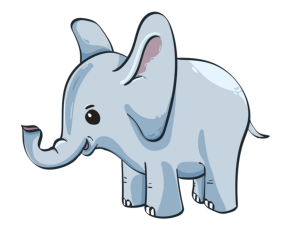

(-0.5, 854.5, 689.5, -0.5)

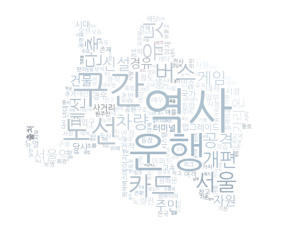

In [73]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


target_image = Image.open("elephant.png")
plt.imshow(target_image)
plt.axis("off")
plt.show()
target_image_mask = np.array(target_image)
color_func = ImageColorGenerator(target_image_mask)
wordcloud = WordCloud(font_path='NanumGothic', background_color='white', mask=target_image_mask, color_func=color_func).fit_words(filtered_paragraph)
plt.imshow(wordcloud)
plt.axis("off")
# wordcloud.to_image().show()
# wordcloud.to_file('test.jpg')

In [ ]:
import requests
random_image = Image.open(requests.get("https://picsum.photos/1920/1200", stream=True).raw)